In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from util import read_instances

def draw_mcp_graph(routes, distance_matrix, plot_title="MCP Graph"):
    G = nx.DiGraph()

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']

    for i in range(len(distance_matrix)):
        G.add_node(i)

    # Add edges based on the routes and distance matrix
    for idx, route in enumerate(routes):
        color = colors[idx % len(colors)]
        route = [0] + [node for node in route if node != 0] + [0]  # Include the depot at start and end
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            weight = distance_matrix[u-1][v-1]
            G.add_edge(u, v, color=color, weight=weight)

    # Use spring layout for better node positioning
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    edges = G.edges(data=True)
    edge_colors = [e[2]['color'] for e in edges]
    edge_weights = nx.get_edge_attributes(G, 'weight')

    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_color='lightgrey', node_size=500, font_size=10, font_color='black')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
    plt.title(plot_title)
    plt.show()

In [2]:
import ast

def plot_solution(instance_path):
    D = read_instances(instance_path)[-1]
    import os
    os.environ["AMPL_LICENSE"] = "e69fc5e3-52d1-49b8-83b7-f1048bd93eda"
    out = !python mcp.py {instance_path} mip highs 299 | grep sol:
    
    sol_str = out[0].replace('sol:', '').strip()
    sol_list = ast.literal_eval(sol_str)
    draw_mcp_graph(sol_list, D)

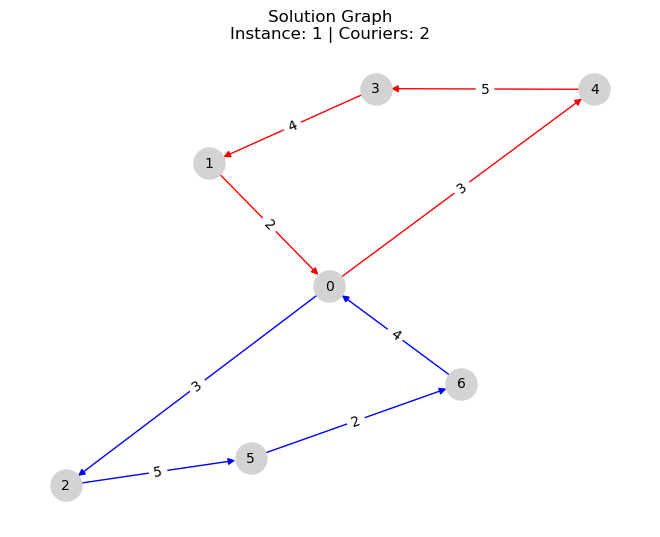

In [4]:
for i in range(1, 2):
    plot_solution(f'./Instances/inst0{i}.dat')

In [54]:
import os
import json 
import pandas as pd

directory_path = './res/MIP'
json_files = sorted([file for file in os.listdir(directory_path) if file.endswith('.json')], key=lambda x: int(os.path.splitext(x)[0]))
all_json_data = []
header = ['ID']

for json_file in json_files:
    file_path = os.path.join(directory_path, json_file)
    with open(file_path, 'r', encoding='utf-8') as file:
        json_content = json.load(file)
        row_data = {}
        for key, value in json_content.items():
            parts = key.split('_')
            solver_name = parts[-1].upper() + ('_SB' if parts[-2] == 'SB' else '')
            if solver_name not in header:
                header.append(solver_name)
                
            row_data[f'{key}_obj'] = int(value.get('obj', None))
            row_data[f'{key}_time'] = value.get('time', None)
        all_json_data.append(row_data)
        
df = pd.DataFrame(all_json_data)
df.insert(0, 'ID', range(1, len(df) + 1))
obj_columns = [col for col in df.columns if 'obj' in col]

print(header)
latex_table = df[['ID'] + obj_columns].to_latex(index=False, column_format="c|ccccc", header=header)
latex_table = latex_table.replace('\\toprule\n', '').replace('\\bottomrule\n', '').replace('midrule', 'hline')

print(latex_table)

['ID', 'HIGHS', 'SCIP', 'CBC', 'CBC_SB']
\begin{tabular}{c|ccccc}
ID & HIGHS & SCIP & CBC & CBC_SB \\
\hline
1 & 14 & 14.000000 & 14.000000 & 14.000000 \\
2 & 226 & 226.000000 & 226.000000 & 226.000000 \\
3 & 12 & 12.000000 & 12.000000 & 12.000000 \\
4 & 220 & 220.000000 & 220.000000 & 220.000000 \\
5 & 206 & 206.000000 & 206.000000 & 206.000000 \\
6 & 322 & 322.000000 & 322.000000 & 322.000000 \\
7 & 167 & 167.000000 & 167.000000 & 167.000000 \\
8 & 186 & 186.000000 & 186.000000 & 186.000000 \\
9 & 436 & 436.000000 & 436.000000 & 436.000000 \\
10 & 244 & 244.000000 & 244.000000 & 244.000000 \\
11 & 530 & 608.000000 & NaN & NaN \\
12 & 433 & NaN & 341.000000 & NaN \\
13 & 373 & NaN & NaN & NaN \\
\end{tabular}



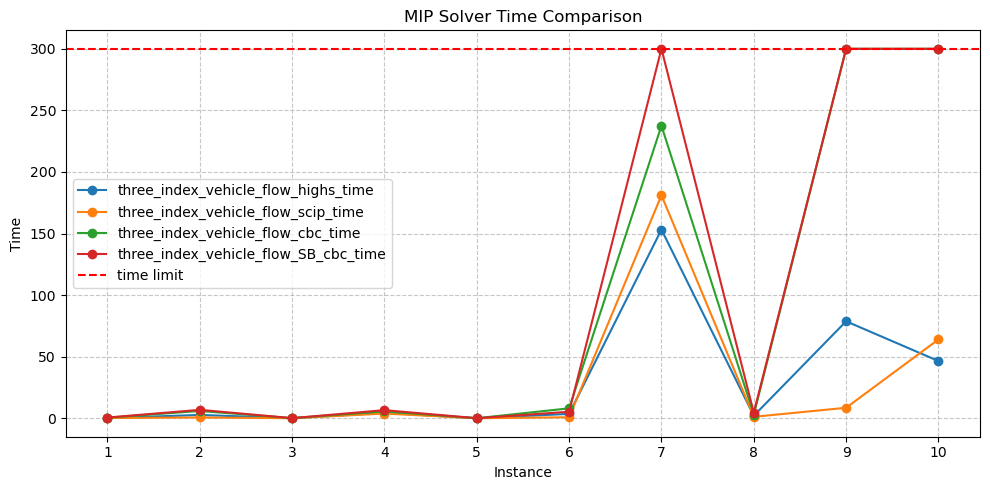

In [55]:
time_columns = [col for col in df.columns if 'time' in col]
ax = df.head(10).plot(x='ID', y=time_columns, figsize=(10, 5), marker='o')
ax.axhline(y=300, color='red', linestyle='--', linewidth=1.5, label='time limit')

ax.set_title("MIP Solver Time Comparison")
ax.set_xlabel("Instance")
ax.set_ylabel("Time")

ax.set_xticks(df['ID'].head(10))

ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.7)

plt.tight_layout()
plt.savefig('./images/test.pdf', dpi=300)  